In [1]:
from data_loaders.dreem import DreemDataset
import numpy as np
import pandas as pd
import torch
import json

### outlier detection

In [ ]:
d = DreemDataset("data/dreem/train/",transform=[dict(type="minmaxscaler")])

In [ ]:
X=d.data

In [ ]:
c= X[:,0,:]
id_list =  np.split(c,c.shape[0]/40,axis=0)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
def get_outliers(trials_list):
    
    main_stats = pd.DataFrame(trials_list.T).describe().T.drop(columns=["min","max","count"])
    outlier_detection = DBSCAN(  eps = .2, 
                                 metric="euclidean", 
                                 min_samples = 3,
                                 n_jobs = -1)
    
    #scale main stats
    scaler = MinMaxScaler() 
    
    main_stats = scaler.fit_transform(main_stats)
    clusters = outlier_detection.fit_predict(main_stats)
    return np.argwhere(clusters<0).squeeze(1)

In [ ]:
import concurrent.futures
from tqdm.notebook import tqdm

In [ ]:
bad_trials={}
with concurrent.futures.ProcessPoolExecutor() as ex:
    for chan  in range(7):
        c= X[:,chan,:]
        id_list =  np.split(c,c.shape[0]/40,axis=0)
        bad_trials[chan] =  list(tqdm(ex.map(get_outliers, id_list), 
                                total = len(id_list),
                                desc = f'channel {chan}',
                                leave = False))

In [ ]:
test = [bad_trials[chan] for chan in range(7)]

In [ ]:
agg=[list(set(np.concatenate(k).tolist())) for k in zip(*test)]

In [ ]:
with open("outliers.json","w") as f:
    json.dump(dict(out=agg),f)

In [ ]:
%matplotlib notebook
idv=879
nogood=list(agg[idv])
good =  [k for k in t if k not in nogood]

pd.DataFrame(xx[idv][good,:,:].reshape(-1,500).T).plot()

### optimal freq range detection

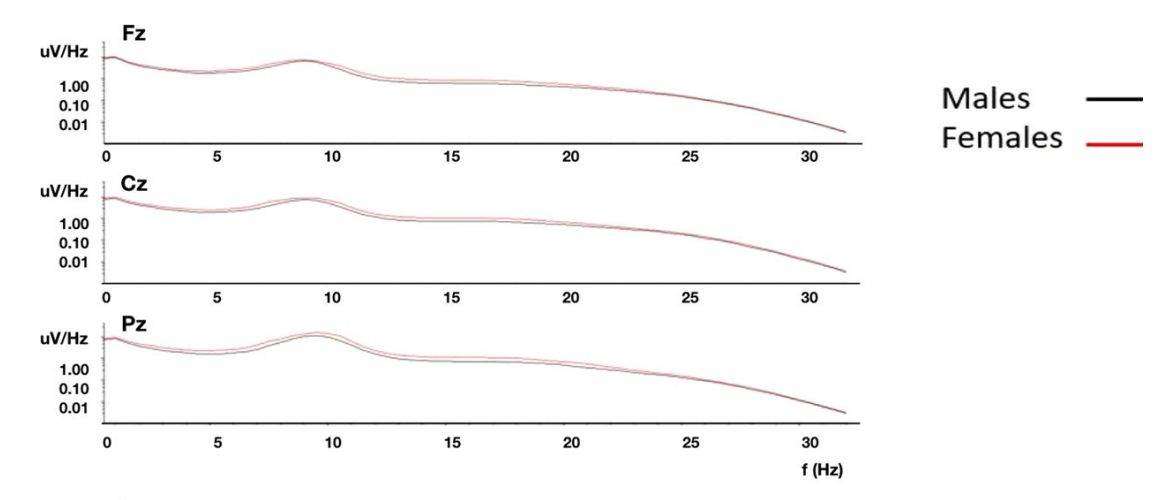

#### Shown is the log-transformed amplitude spectrum in the frequency range 0.5–35Hz from three
#### electrode positions (Fz, Cz, and Pz). Power is slightly increased at all frequencies for females, most prominent
#### in the beta band (12–25Hz) 
#### (https://www.nature.com/articles/s41598-018-21495-7.pdf)

### => Let's try to find something similar  in our dreem dataset

In [ ]:
!pwd

In [ ]:
outliers=[14,721,439,943,934,622,149,460,556,220,219,603,519,788,799,191,402]

d=DreemDataset("data/DREEM/train/",transform=[{"type": "outliers", "args":{"out":outliers}}])

labels= pd.Series(d.labels.squeeze())

M_idx=labels[labels==0].index.values
F_idx=labels[labels==1].index.values

In [ ]:
M=d.data[M_idx,:,:]
F=d.data[F_idx,:,:]

In [ ]:
from torchaudio.transforms import Spectrogram

In [ ]:
s=Spectrogram(n_fft=500,normalized=True,power=2)

In [ ]:
M_spectr=[]
F_spectr=[]

In [ ]:
MM=np.array(np.split(M,M.shape[0]/40,axis=0))
FF=np.array(np.split(F,F.shape[0]/40,axis=0))

In [ ]:
for k in range(7):
    M_spectr.append(s(torch.tensor(M[:,k,:])).log2()[:,:,1].mean(axis=0).numpy())
    F_spectr.append(s(torch.tensor(F[:,k,:])).log2()[:,:,1].mean(axis=0).numpy())

In [ ]:
def get_freq_range(sampling_rate,window_size):
    return [sampling_rate/window_size *k for k in range(window_size//2+1)]

In [ ]:
#%matplotlib notebook
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))

freq = get_freq_range(250,500)
for k in range(7):
    plt.plot(freq,(M_spectr[k]-F_spectr[k])/(F_spectr[k]+30))

ax=plt.gca()
ax.set_xlim(left=0,right=130)
plt.xticks(np.arange(min(freq), max(freq)+1, 5.0))
good_bands=(50 , 60,100 )
  
for k in good_bands:
    ax.axvspan(k-3, k+3, alpha=0.3, color='red')



In [ ]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def gen_filter(x,low,high,fs=250,order=9):
    return abs(butter_bandpass_filter(x,low,high,fs,order))

In [ ]:
import concurrent.futures
from tqdm.notebook import tqdm
from functools import partial
def process(band_min,band_max):
    
    resH={}
    resF={} 
    
    def foo(chan,IND):
        return gen_filter(IND[chan,:],band_min,band_max).sum()
  
            
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as ex:
        print(f'({band_min},{band_max}) processing males...')
        for  chan  in tqdm(range(7), desc='males'):
            resH[chan] =  list(tqdm(ex.map(partial(foo,chan), M), 
                                total = len(M),
                                desc = f'channel {chan}',
                                leave = False))

        print(f'({band_min},{band_max}) processing females...')
        for  chan  in tqdm(range(7), desc='females'):
            resF[chan] =  list(tqdm(ex.map(partial(foo,chan), F), 
                                    total = len(F),
                                    desc = f'channel {chan}',
                                    leave = False))
                
                
    dH = pd.DataFrame(resH).unstack(0).reset_index(0)
    dH.columns  = ["channel","response_level"]
    dH['sex'] = 'male'

    dF = pd.DataFrame(resF).unstack(0).reset_index(0)
    dF.columns  = ["channel","response_level"]
    dF['sex'] = 'female'
    
    res= pd.concat([dH,dF])
    res['band_filter'] = f"{band_min}_{band_max}"
    return res

In [ ]:
res=pd.concat([process(48,52),process(59,63),process(98,102)]).reset_index(drop=True)

In [ ]:
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px

In [ ]:
figres=[]
for x in res.band_filter.unique():
    tmp = res[res.band_filter==x]
    q = tmp.response_level.quantile(0.85)
    tmp = tmp[tmp.response_level<q]
    fig = px.box(tmp,title=f"Response to band filter {x}", y="response_level", x="channel", color="sex", points=None, hover_data=tmp.columns)
    fig.write_html(f"res_{x}.html")

In [ ]:
N_idv = data.shape[0]
N_trials =data.shape[1]
        
keep_idx = np.delete(np.arange(N_idv * N_trials),[1,1900,10000])
   

In [ ]:
import h5py
import numpy as np
data= h5py.File("data/DREEM/train/X_train_new.h5",'r').get('features') 

In [ ]:
test = np.vstack([k.squeeze(axis=1) for k in np.split(data, N_trials, axis=1)])[keep_idx]

In [ ]:
import pandas as pd

In [ ]:
 labels = pd.read_csv("data/DREEM/train/y_train_AvCsavx.csv",index_col='id').values